## VARIATIONAL QUANTUM CLASSIFIER ##

In [8]:
#!pip install imblearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes

from qiskit.algorithms.optimizers import COBYLA


from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms.classifiers import VQC  

from IPython.display import clear_output


/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_18870/3684460210.py:17: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In [2]:
file_path = "dataset/dataset.csv"

In [3]:
try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()

Dataset imported successfully.


In [4]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

print(df.head())

   age gender             category  amount  fraud
0  '4'    'M'  'es_transportation'    4.55      0
1  '2'    'M'  'es_transportation'   39.68      0
2  '4'    'F'  'es_transportation'   26.89      0
3  '3'    'M'  'es_transportation'   17.25      0
4  '5'    'M'  'es_transportation'   35.72      0


In [5]:
encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0


Undersampling to have a balanced dataset:

In [6]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Check class distribution
print("Class distribution before undersampling:")
print(y.value_counts())

#---------------------------------------------------------------------------
# To have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}
#---------------------------------------------------------------------------

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution before undersampling:
fraud
0    587443
1      7200
Name: count, dtype: int64
Class distribution after undersampling:
fraud
0    100
1    100
Name: count, dtype: int64


In [7]:
X_resampled = MinMaxScaler().fit_transform(X_resampled)

Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


We try different feature map to encode our data:

- PauliFeatureMap
- ZFeatureMap
- ZZFeatureMap

/Users/edoardozappia/opt/anaconda3/envs/qiskit-stable/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


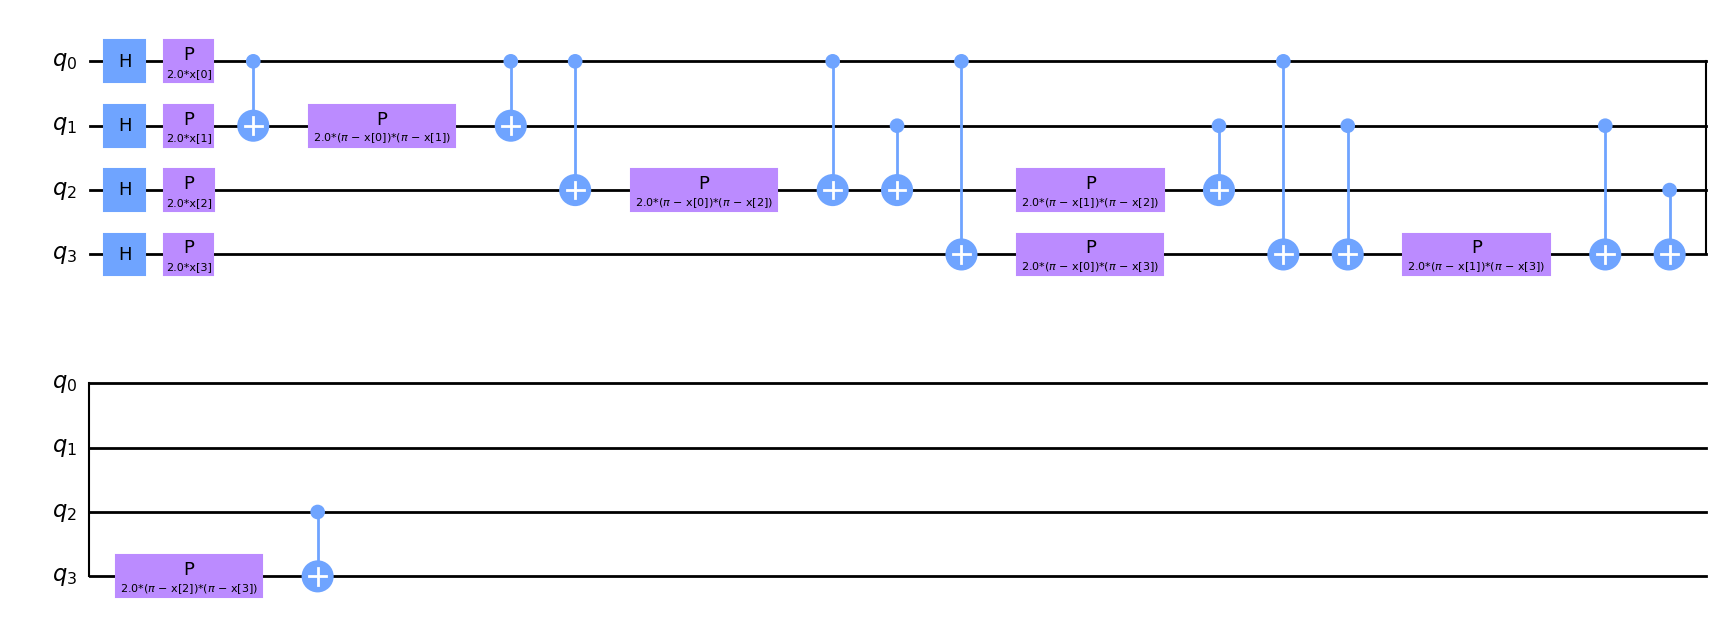

In [9]:
ZZ = ZZFeatureMap(feature_dimension=4, reps=1)                   # ZZFeatureMap seems better
ZZ.decompose().draw(output='mpl')

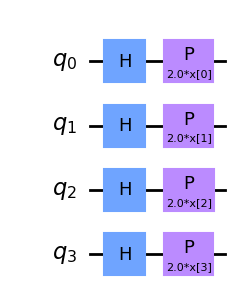

In [10]:
Z = ZFeatureMap(feature_dimension=4, reps=1)
Z.decompose().draw(output='mpl')

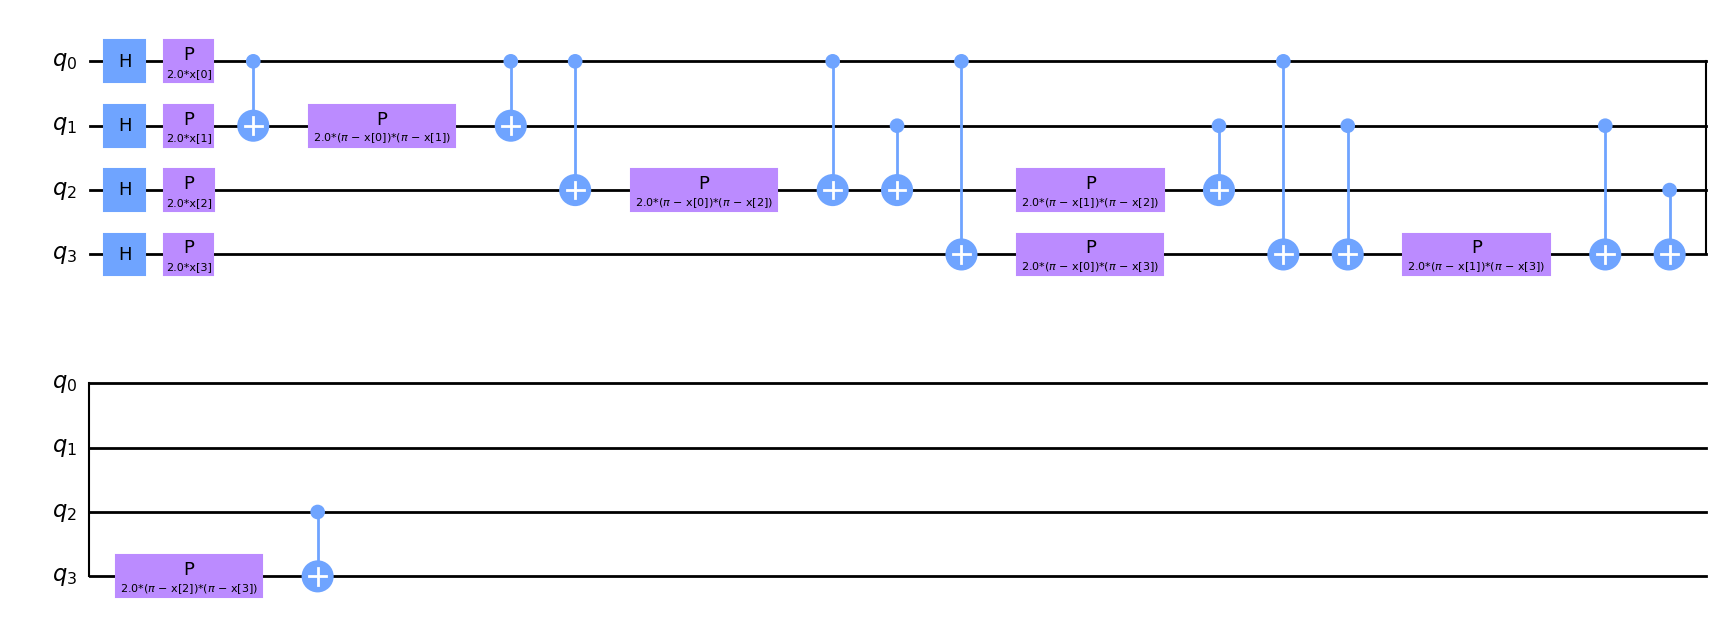

In [11]:
P = PauliFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features
P.decompose().draw(output='mpl')

Parametrized Quantum Circuit

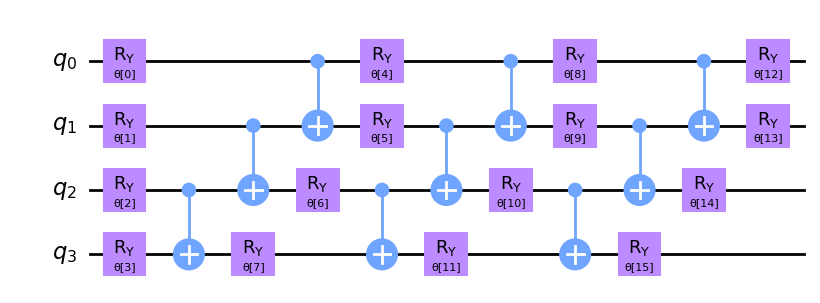

In [12]:
pqc = RealAmplitudes(num_qubits=4, reps=3)  # num_qubits = num_features
pqc.decompose().draw(output='mpl')

In [13]:
optimizer = COBYLA(maxiter=10)
sampler = Sampler()

objective_func_vals_Z = []
objective_func_vals_ZZ = []
objective_func_vals_P = []

# a callback that can access the intermediate data during the optimization
def callback(feature_map_name, obj_func_eval):
    if feature_map_name == 'Z':
        objective_func_vals_Z.append(obj_func_eval)
    elif feature_map_name == 'ZZ':
        objective_func_vals_ZZ.append(obj_func_eval)
    elif feature_map_name == 'P':
        objective_func_vals_P.append(obj_func_eval)
    
    clear_output(wait=True)
    
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals_Z)), objective_func_vals_Z, label='Z')
    plt.plot(range(len(objective_func_vals_ZZ)), objective_func_vals_ZZ, label='ZZ')
    plt.plot(range(len(objective_func_vals_P)), objective_func_vals_P, label='P')
    plt.legend()
    plt.show()

vqc_Z = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=pqc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z', obj_func_eval),
)

vqc_ZZ = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=pqc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ', obj_func_eval),
)

vqc_P = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=pqc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('P', obj_func_eval),
)

In [26]:
# vqc.fit wants ndarray as input

y_train_np = y_train.values
y_test_np = y_test.values

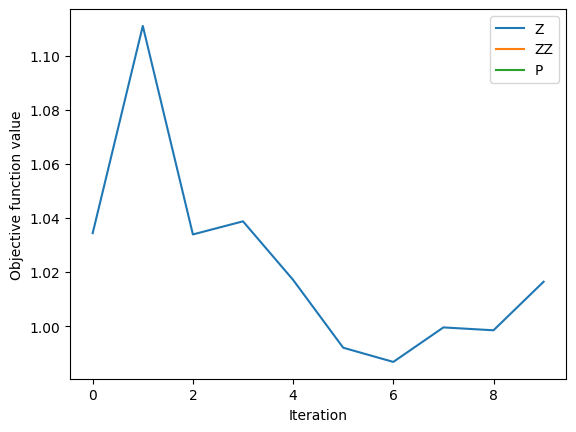

CPU times: user 19.3 s, sys: 1.5 s, total: 20.8 s
Wall time: 17.4 s


In [23]:
%%time

vqc_Z.fit(X_train, y_train_np)

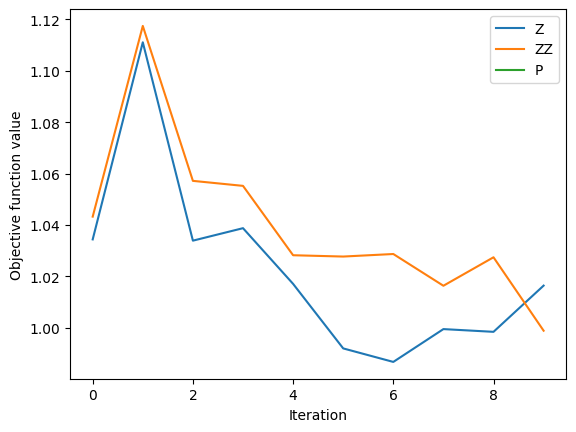

CPU times: user 28 s, sys: 1.51 s, total: 29.5 s
Wall time: 26.3 s


In [24]:
%%time

vqc_ZZ.fit(X_train, y_train_np)

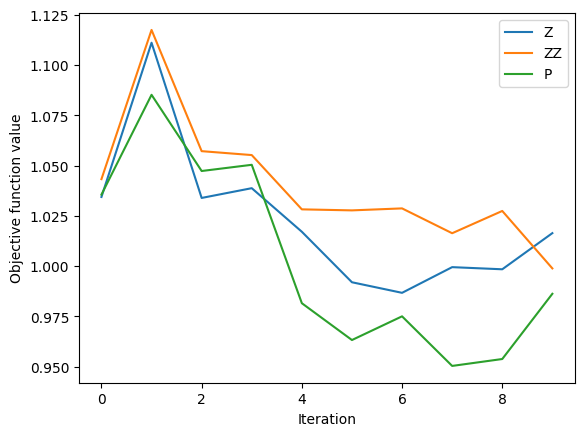

CPU times: user 28.1 s, sys: 1.52 s, total: 29.6 s
Wall time: 26.7 s


In [25]:
%%time

vqc_P.fit(X_train, y_train_np)

In [32]:
def evaluate_with_feature_map(vqc, X_train, y_train, X_test, y_test, feature_map_name):
    # Perform predictions on training and test sets
    y_train_pred = vqc.predict(X_train)
    y_test_pred = vqc.predict(X_test)
    
    # Print classification report and confusion matrix for training set
    print(f"Classification Report for {feature_map_name} Feature Map (Train Set):\n")
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")
    print(confusion_matrix(y_train_np, y_train_pred))
    print("\n")
    
    # Print classification report and confusion matrix for test set
    print(f"Classification Report for {feature_map_name} Feature Map (Test Set):\n")
    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))
    
    # Print ROC AUC score for test set
    print(f"ROC AUC Score for {feature_map_name} Feature Map (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred), 2))
    print("\n\n")

In [33]:
vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P}

for feature_map_name, vqc_model in vqc_models.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.51      0.82      0.63        71
           1       0.52      0.20      0.29        69

    accuracy                           0.51       140
   macro avg       0.52      0.51      0.46       140
weighted avg       0.52      0.51      0.46       140

Confusion Matrix for Train Set:
[[58 13]
 [55 14]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.52      0.79      0.63        29
           1       0.62      0.32      0.43        31

    accuracy                           0.55        60
   macro avg       0.57      0.56      0.53        60
weighted avg       0.58      0.55      0.52        60

Confusion Matrix for Test Set:
[[23  6]
 [21 10]]
ROC AUC Score for Z Feature Map (Test Set):
0.56



Evaluating performance for ZZ Feature Map